# Word based prediction

In [1]:
import keras
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, Bidirectional, Embedding
from keras import regularizers
from keras.callbacks import LambdaCallback
import random

path = keras.utils.get_file(
    fname="don_quijote.txt", 
    origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219424&authkey=AH0gb-qSo5Xd7Io"
)
text = open(path,encoding='UTF-8').read().lower()

Using TensorFlow backend.


Preprocesamiento de los datos, para eliminar signos de puntuación y extraer solo las palabras más frecuentes

In [2]:
def multi_replace(text, mapping):
    """
    Replace occurences in text basedon mapping
    """
    import re
    
    # Generate something like: r'\.|\,|\¿|\?|\!|\;|\-'
    regexp = re.compile('|'.join(map(re.escape, mapping)))
    
    # Replace each occurence of a match string with its value
    sub_sentences = regexp.sub(lambda match: mapping[match.group(0)], text)
    
    return sub_sentences

# Generate a word index
sentences = text.replace('\n', ' ')

special_chars = {'.':' <END>',
           ',':' <COM>',
           '¿':' <QUEST1>',
           '?':' <QUEST2>',
           '!':' <INDIC>',
           ';': ' <SEMI>',
           '-': ' <BAR> ',
          }

cleaned = multi_replace(sentences, special_chars)
word_sequence = cleaned.split(' ')
unique_words = set(word_sequence)
print('%d words in total\n%d unique words' % (len(word_sequence), len(unique_words)))

453966 words in total
24135 unique words


In [3]:
# Get most common words
word_freq_dict = {}
for word in word_sequence:
    cnt = word_freq_dict.get(word, 0)
    word_freq_dict[word] = cnt+1

# Remove '' spaces spaces?
word_freq_dict.pop('')

word_freq = [(v, k) for k, v in word_freq_dict.items()]
word_freq = sorted(word_freq, reverse=True)

# Get 95% coverage of all word occurences in the text
acc_threshold = len(word_sequence)*0.95

N = 0
word_list = []
for n, w in word_freq:
    N+=n
    if N > acc_threshold:
        break
    word_list.append(w)

word_list.insert(0, '<UNKNOWN>')
word_index = {w:i for i, w in enumerate(word_list)}

print('Keeping %d words from the %d unique words' % (len(word_list), len(unique_words)) )

Keeping 17661 words from the 24135 unique words


Se crean los embeddings

In [4]:

def text_embedded(text, word_index, default=0):
    """
    Helper function that encodes given text using encoding (like embedding)
    """
    enc = []
    for w in text:
        enc.append(word_index.get(w, default))
    return np.array(enc)

emtext = text_embedded(word_sequence, word_index)
emtext[0:100]

array([  263,   222,     9,     2,   948,     4,     5,   565,     3,
         717,    22,   459,   613,    21,    25,     4,     5,   250,
           0,     0,     7,    31,   124,     4,     5,   250,     1,
           4,   639,   230,    11,   165,  8203,     1,    11,    45,
         147,   135,     2,  1914,    31,   613,     4,    13,     4,
         601,     7, 11544,     1,  1734,  1904,     1,  1930,  2677,
           3,  7430,  7800,     9,    38,  3090,     4,   324,    29,
        3281,     2,  7918,     1,  8870,    17,    29,  2061,     1,
        5043,     3, 14707,    13, 13241,     1, 17086,    13,  2772,
           1,   153, 15630,     4,  2250,    13, 10689,     1,     0,
          17,   185,   399,     4,    20,   730,     9,     8,  5526,
         395])

Se crean las secuencias, esta vez a partir de los embeddings correspondientes a las palabras, en lugar de los caracteres

In [5]:
# Definimos el tamaño de las secuencias. Puedes dejar este valor por defecto.
SEQ_LENGTH = 15
DICT_SIZE = len(word_index)

sequences = []
next_word = []

# NOTE: is this a bug? But full_sequence has to be 31 of length, not 30!
full_sequence = [emtext[i:i+j+1] for i in range(len(emtext)-SEQ_LENGTH) for j in range(SEQ_LENGTH,SEQ_LENGTH+1)]

for sequence in full_sequence:
    sequences.append(sequence[:-1])
    next_word.append(sequence[-1])

print('Generated %d Sequences' % (len(sequences)))

Generated 453951 Sequences


In [0]:
MAX_SEQUENCES = len(sequences)
#MAX_SEQUENCES = 100000 #En este caso hemos utilizado un número de secuencias mayor
#MAX_SEQUENCES = 50000
MAX_SEQUENCES = 10000
#MAX_SEQUENCES = 500

perm = np.random.permutation(len(sequences))
sequences_short, next_word_short = np.array(sequences), np.array(next_word)
sequences_short, next_word_short = sequences_short[perm], next_word_short[perm]
sequences_short, next_word_short = list(sequences_short[:MAX_SEQUENCES]), list(next_word_short[:MAX_SEQUENCES])

# Generate training data
x_train = np.array(sequences_short)

# One hot encode next_word
y_train = np.zeros((MAX_SEQUENCES, DICT_SIZE))
for i, w in enumerate(next_word_short):
    y_train[i][w] = 1

Funciones auxiliares para mostrar gráficas en el entrenamiento

In [0]:
from matplotlib import pyplot as plt

def plot_acc(history, title="Model Accuracy", ax=None):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)        
    ax.plot(history.history['acc'])
    ax.plot(history.history['val_acc'])
    ax.set_title(title)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    
def plot_loss(history, title="Model Loss", ax=None):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)  
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Val'], loc='upper right')

def plot_training(history):
    # Print learning progress
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))  
    plot_acc(history=history, ax=axs[0])
    plot_loss(history=history, ax=axs[1])
    fig.suptitle('Training Progress')

In [0]:
def sample(probs, temperature=1.0):
    """Nos da el índice del elemento a elegir según la distribución
    de probabilidad dada por probs.
    
    Args:
      probs es la salida dada por una capa softmax:
        probs = model.predict(x_to_predict)[0]
      
      temperature es un parámetro que nos permite obtener mayor
        "diversidad" a la hora de obtener resultados. 
        
        temperature = 1 nos da la distribución normal de softmax
        0 < temperature < 1 hace que el sampling sea más conservador,
          de modo que sampleamos cosas de las que estamos más seguros
        temperature > 1 hace que los samplings sean más atrevidos,
          eligiendo en más ocasiones clases con baja probabilidad.
          Con esto, tenemos mayor diversidad pero se cometen más
          errores.
    """
    # Cast a float64 por motivos numéricos
    probs = np.asarray(probs).astype('float64')
    
    # Hacemos logaritmo de probabilidades y aplicamos reducción
    # por temperatura.
    probs = np.log(probs) / temperature
    
    # Volvemos a aplicar exponencial y normalizamos de nuevo
    exp_probs = np.exp(probs)
    probs = exp_probs / np.sum(exp_probs)
    
    # Hacemos el sampling dadas las nuevas probabilidades
    # de salida (ver doc. de np.random.multinomial)
    samples = np.random.multinomial(1, probs, 1)
    maxidx = np.argmax(samples)
    #return min(max(maxidx, 0), len(probs)-1)
    return maxidx


Se vuelven a crear las funciones generate_text y predict_text, adaptándola al caso de predicción en base a palabras.

In [0]:
TEMPERATURES_TO_TRY = [0.2, 0.5, 1.0, 1.2]
GENERATED_TEXT_LENGTH = 20

def generate_text_byword(seed_text, model, length, temperature=1):
    """Genera una secuencia de texto a partir de seed_text utilizando model.
    
    La secuencia tiene longitud length y el sampling se hace con la temperature
    definida.
    """
    
    # Aquí guardaremos nuestro texto generado, que incluirá el
    # texto origen
 
    ### TU CÓDIGO AQUÍ
    generated = predict_text_byword(seed_text, model, GENERATED_TEXT_LENGTH)

    ### FIN DE TU CÓDIGO
    decoded_text = ' '.join([word_list[i] for i in generated])
    return decoded_text



def predict_text_byword(seed_text, model, length):
    generated = list(seed_text)
    N = len(seed_text)
    for i in range(length):
        text = np.array(generated[-N:])
        # Reshape encoded text, because model expects (X, SEQ_LENGTH, NUM_CARS)
        text = np.reshape(text, (1,) + text.shape)
        #print('Enter %s' % text)
        prediction = model.predict(text)
        predicted = sample(prediction[0])
        #predicted = np.argmax(prediction[0])
        #print('Predicted %d' % predicted)
        generated.append(predicted)
    return generated


def on_epoch_end(epoch, logs):
  print("\n\n\n")
  
  # Primero, seleccionamos una secuencia al azar para empezar a predecir
  # a partir de ella
  start_pos = random.randint(0, len(emtext) - SEQ_LENGTH - 1)
  seed_text = list(emtext[start_pos:start_pos + SEQ_LENGTH])
  for temperature in TEMPERATURES_TO_TRY:
    print("------> Epoch: {} - Generando texto con temperature {}".format(
        epoch + 1, temperature))
    
    generated_text = generate_text_byword(seed_text, model, 
                                   GENERATED_TEXT_LENGTH, temperature)
    print("Seed: {}".format(' '.join([word_list[i] for i in seed_text])))
    print("Texto generado: {}".format(generated_text))
    print()
generation_callback = LambdaCallback(on_epoch_end=on_epoch_end)  


Se crea el modelo, utilizando una red LSTM bidireccional

In [12]:
# Add early stopping and only storing the best model
callbacks = [EarlyStopping(monitor='val_loss', patience=4, min_delta=0.02),
             ModelCheckpoint('weights-best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
             generation_callback,
            ]

EMBEDDING_DIM = 100


model = Sequential()
model.add(Embedding(len(word_index)+1, EMBEDDING_DIM, input_length=SEQ_LENGTH))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(len(word_index), activation='softmax'))


"""
model = Sequential()
model.add(Embedding(len(word_index)+1, EMBEDDING_DIM, input_length=SEQ_LENGTH))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(len(word_index), activation='softmax'))
"""

model.summary()

W0614 21:08:09.101253 140266812942208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0614 21:08:09.158629 140266812942208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0614 21:08:09.172867 140266812942208 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 100)           1766200   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_1 (Dense)              (None, 17661)             4538877   
Total params: 6,539,573
Trainable params: 6,539,573
Non-trainable params: 0
_________________________________________________________________


Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 40s 5ms/step - loss: 4.5336 - acc: 0.1661 - val_loss: 6.7916 - val_acc: 0.0815

Epoch 00001: val_acc did not improve from 0.10400




------> Epoch: 1 - Generando texto con temperature 0.2
Seed: <COM> desde aquel día en adelante <COM> vargas y machuca <END> <UNKNOWN> dicho esto <COM>
Texto generado: <COM> desde aquel día en adelante <COM> vargas y machuca <END> <UNKNOWN> dicho esto <COM> yo pues y esta quisiéredes dulcinea a servido dicho <QUEST2> <UNKNOWN> <UNKNOWN> no yo que ha tengo el estaba merced

------> Epoch: 1 - Generando texto con temperature 0.5
Seed: <COM> desde aquel día en adelante <COM> vargas y machuca <END> <UNKNOWN> dicho esto <COM>
Texto generado: <COM> desde aquel día en adelante <COM> vargas y machuca <END> <UNKNOWN> dicho esto <COM> quiero otra invención he tocino <INDIC> yo <BAR> lo leonela <SEMI> la mal iba me trabacuentas gritos <END> <END> <BAR>

------> Ep

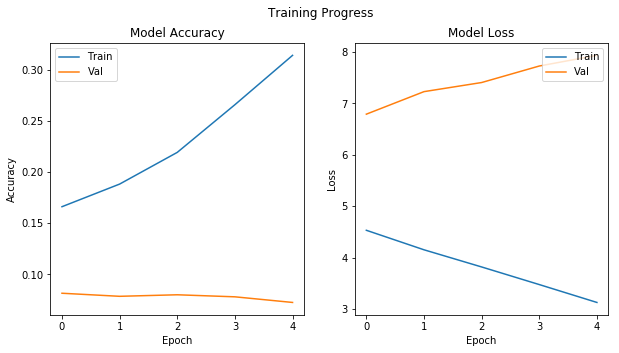

In [18]:

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

%time history = model.fit(x_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.2, callbacks=callbacks)

#test_loss, test_acc = model.evaluate(x_test_cut, y_test)
#print('Test acc: %0.3f' % test_acc)

plot_training(history)